In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from itertools import combinations
from scipy.spatial.distance import cdist

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def import_data(file_name, col_list, seperator):
    df = pd.read_csv(file_name, sep=seperator, usecols=col_list )
    return df

In [45]:
def cluster_pair_list(df, pair_list, no_of_clusters, n):
    for pair in pair_list:
        df1 = df[list(pair)]
        kmeans = KMeans(n_clusters=no_of_clusters)
        distance = kmeans.fit_transform(df1)
        center = kmeans.cluster_centers_
        labels = kmeans.labels_
        df1['labels'] = labels
        
        local_c, local_f = local_closests_farthests(df1, distance, labels, n)
        outliers = global_outliers(df1, list(pair), center)
        
        plot_clusters(df1, outliers, local_c, local_f, pair, center, labels)

In [80]:
def plot_clusters(df, outliers, local_c, local_f, col_list, center, labels):
    if len(col_list)==1:
        ax = df.reset_index().plot(kind='scatter',x='index',y=col_list[0], c=labels, cmap='viridis')
        outliers.reset_index().plot(kind='scatter',x='index',y=1, marker='+' ,c='k',s=100, ax=ax)
        local_c.reset_index().plot(kind='scatter',x='index',y=col_list[0], c='b', ax=ax, marker='x', s=60)
        local_f.reset_index().plot(kind='scatter',x='index',y=col_list[0], c='m', ax=ax, marker='x', s=60)

    elif len(col_list)==2:
        ax = df.plot(kind='scatter',x=col_list[0],y=col_list[1],c=labels, cmap='viridis')
        ax.scatter(center[:,0],center[:,1], c='r', marker='*', s=80)
        outliers.plot(kind='scatter',x=0,y=1, marker='+' ,c='k',s=100, ax=ax)
        local_c.reset_index().plot(kind='scatter',x=col_list[0],y=col_list[1], c='b', ax=ax, marker='x', s=60)
        local_f.reset_index().plot(kind='scatter',x=col_list[0],y=col_list[1], c='m', ax=ax, marker='x', s=60)
        
    elif len(col_list)==3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df[col_list[0]], df[col_list[1]], df[col_list[2]], c=labels, cmap='viridis')
        ax.scatter(center[:,0],center[:,1],center[:,2], c='r', s=50)
        ax.scatter(outliers[col_list[0]], outliers[col_list[1]], outliers[col_list[2]], c='k', s=100, marker='+')
        local_c.reset_index().plot(kind='scatter',x='index',y=col_list[0], c='b', ax=ax, marker='x', s=60)
        local_f.reset_index().plot(kind='scatter',x='index',y=col_list[0], c='m', ax=ax, marker='x', s=60)
        
    else:
        col_list = col_list + ('labels',)
        print('\n' + '\033[1m' + 'The data with corresponding cluster labels:' +'\033[0m')
        print(df[list(col_list)])
        print('\n' + '\033[1m' + 'Global outliers:' +'\033[0m')
        print(outliers[list(col_list)])
        print('\n' + '\033[1m' +'Local closests:' + '\033[0m')
        print(local_c[list(col_list)])
        print('\n' + '\033[1m' +'Local farthests:' + '\033[0m')
        print(local_f[list(col_list)])
    
    if(len(col_list)==1):
        ax.legend(('Clusters pts', 'Outliers', 'Local closests', 'Local farthests'), loc='best')
    elif(len(col_list)<4):
        ax.legend(('Clusters pts', 'Centroids', 'Outliers', 'Local closests', 'Local farthests'), loc='best')

In [46]:
def local_closests_farthests(df, distance, labels, n):
    distance = distance**2
    distance = distance.min(axis=1)
    df['Dist'] = distance
    df['labels'] = labels
    local_c = pd.DataFrame()
    local_f = pd.DataFrame()

    for l in np.unique(labels):
        X = df[df['labels']==l]
        X.sort_values(['Dist'], inplace=True)
        local_c = local_c.append(X.head(n))
    for l in np.unique(labels):
        X = df[df['labels']==l]
        X.sort_values(['Dist'], inplace=True, ascending=[0])
        local_f = local_f.append(X.head(n))
    return local_c, local_f

In [7]:
def global_outliers(df, pair, center):
    n = len(center)
    global_center = 0
    for i in range (n):
        global_center = global_center + center[i,:]
    global_center = global_center/n
    df['distance'] = np.linalg.norm(df[pair].sub(np.array(global_center)), axis=1)
    df = df.sort_values(['distance'], ascending=[0]).iloc[0:5, :]
    return df

In [8]:
col_list = ['CID', 'DCID', 'CLUSTID', 'CLUST_VM_Count', 'CLUST_HOST_Count', ' HOST_VMCount ', 'HOSTID']
data = import_data('dc_cluster_host.csv', col_list, ',')

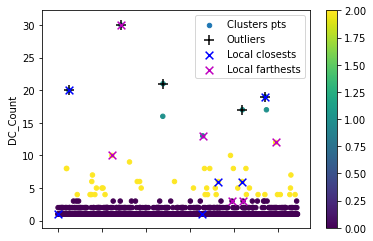

In [73]:
df1 = data[['CID', 'DCID']]
df1 = df1.groupby(by='CID', as_index=False).agg({'DCID': pd.Series.nunique})
df1 = df1.rename(columns={'DCID': 'DC_Count'})
cluster_pair_list(df1, [['DC_Count']], 3, 2)

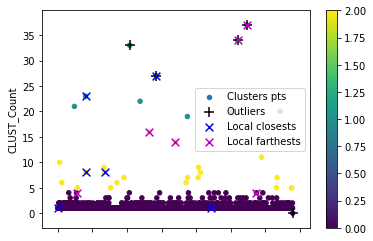

In [74]:
df2 = data[['DCID', 'CLUSTID']]
df2 = df2.groupby(by='DCID', as_index=False).agg({'CLUSTID': pd.Series.nunique})
df2 = df2.rename(columns={'CLUSTID': 'CLUST_Count'})
cluster_pair_list(df2, [['CLUST_Count']], 3, 2)

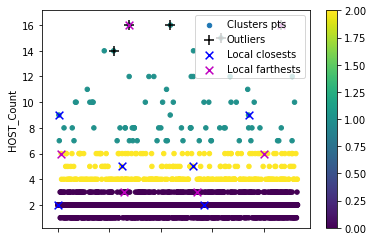

In [75]:
df3 = data[['CLUSTID', 'HOSTID']]
df3 = df3.groupby(by='CLUSTID', as_index=False)['HOSTID'].count()
df3 = df3.rename(columns={'HOSTID': 'HOST_Count'})
cluster_pair_list(df3, [['HOST_Count']], 3, 2)

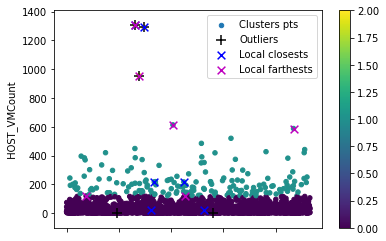

In [76]:
df4 = data[['CLUSTID', ' HOST_VMCount ']]
df4 = df4.groupby(by='CLUSTID', as_index=False)[' HOST_VMCount '].sum()
cluster_pair_list(df4, [[' HOST_VMCount ']], 3, 2)

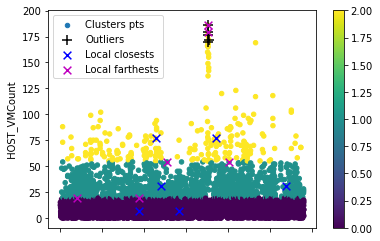

In [77]:
df5 = data[['HOSTID', ' HOST_VMCount ']]
df5 = df5.groupby(by='HOSTID', as_index=False)[' HOST_VMCount '].sum()
cluster_pair_list(df5, [[' HOST_VMCount ']], 3, 2)

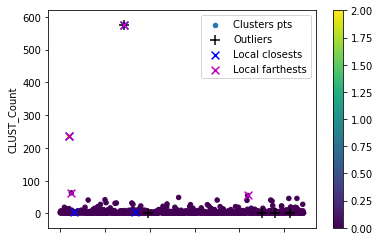

In [78]:
df6 = data[['CID', 'CLUSTID']]
df6 = df6.groupby(by=['CID'], as_index=False)['CLUSTID'].count()
df6 = df6.rename(columns={'CLUSTID': 'CLUST_Count'})
cluster_pair_list(df6, [['CLUST_Count']], 3, 2)

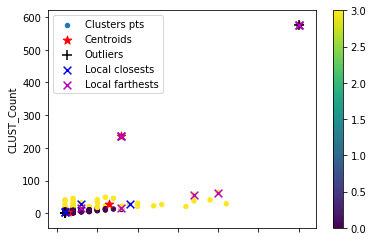

In [81]:
df7 = pd.merge(df1, df6, on='CID')
cluster_pair_list(df7, [['DC_Count', 'CLUST_Count']], 4, 2)